<a href="https://colab.research.google.com/github/heraclex12/Sign-Language-MNIST/blob/master/Sign_Language_MNIST_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from skimage.feature import hog
from skimage import exposure
from skimage.transform import rotate
import pickle
from tqdm import tqdm
import timeit
import pickle
import os
%matplotlib inline
os.chdir('drive/My Drive/Training set')

In [ ]:
def read_file(filename, hist=False):
  """
      Đọc csv theo 2 chế độ:
        1. Nếu hist=True, trả về histogram màu của ảnh có chiều dài 256.
        2. ngược lại, trả về danh sách các véc-tơ có chiều dài là 784.
  """
  df = pd.read_csv(filename)
  if hist:
    pixels = np.empty((df.shape[0], 256))
    for i in range(df.shape[0]):
      tmp = df.iloc[i].value_counts(sort=False).reindex(range(0, 256), fill_value=0).to_numpy()
      pixels[i] = tmp
  else:
    pixels = df.drop(columns=['label']).values
  
  labels = df.label.values
  pixels = pixels.astype(np.float64)
  return pixels, labels

## Plot image data

In [ ]:
def show_image_by_range(pixels, labels, start=0, end=1, img_size=28):
  """
    Hiển thị ảnh từ start tới end

    Parameters
    ----------
    pixels : danh sách véc-tơ ảnh.
    labels : danh sách nhãn của ảnh.
    start : vị trí bắt đầu.
    end : vị trí kết thúc.
    size : kích thước của ảnh.
  """
  pixels_tmp = pixels.reshape(-1, img_size, img_size, 1)
  plt.figure(figsize=(12, 12))
  
  for i in range(start, end):
    plt.subplot((end - start) // 4 + 1, 4, i + 1)
    plt.axis('off')
    plt.title(labels[i])
    plt.imshow(pixels_tmp[i, :, :, 0], cmap='gray')
    
  plt.show()

def show_image_by_condition(pixels, labels, label_condition=None, numbers=24, img_size=28):
  """
    Hiển thị ảnh theo nhãn.
  """
  pixels_tmp = pixels.reshape(-1, img_size, img_size, 1)
  plt.figure(figsize=(12, 12))

  cnt = 0
  if label_condition is None:
    label_condition_set = set(np.unique(y_train))
  else:
    label_condition_set = set(label_condition)

  n_images = len(pixels)
  n_condition = len(label_condition_set)
  cached_label = set()
  while cnt < numbers:
    idx = np.random.randint(0, n_images)
    if labels[idx] in label_condition_set and (labels[idx] not in cached_label or cnt >= n_condition):
      cnt += 1
      cached_label.add(labels[idx])
      plt.subplot(numbers // 4 + 1, 4, cnt)
      plt.axis('off')
      plt.title(labels[idx])
      plt.imshow(pixels_tmp[idx, :, :, 0], cmap='gray')

  plt.show()

## Read data

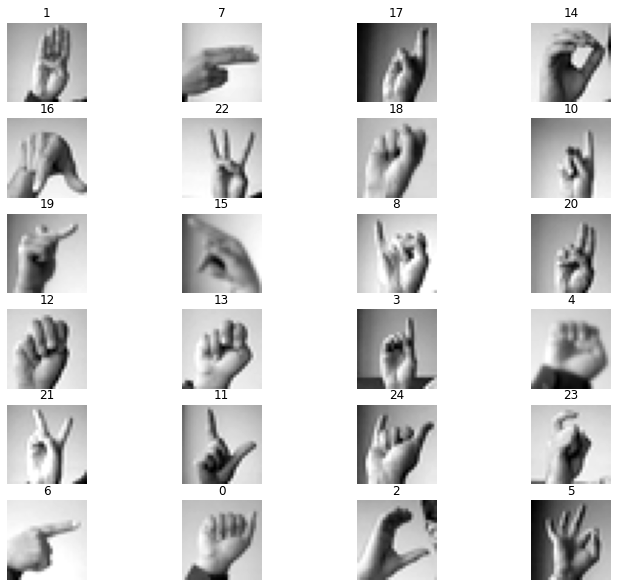

In [ ]:
# read data from csv file
X_train, y_train = read_file('train.csv')

# normalize data from 0 to 1 range 
X_train /= 255

# Visualize images
show_image_by_condition(X_train, y_train, numbers=24)

Trong quá trình đánh giá các mô hình để so sánh, nhóm em lựa chọn sử dụng phương thức Cross-Validation, chia tập dữ luyện huấn luyện thành 5 phần và lần lượt đánh giá để lấy ra được kết quả trung bình cuối cùng.

## Baseline

Dưới đây nhóm em triển khai một mô hình Logistic Regression với siêu tham số max_iter=10000 để tăng số vòng lặp tính toán trọng số của mô hình nhằm giúp mô hình hội tụ. Mô hình này được lựa chọn làm baseline để cải tiến.

In [ ]:
# Train baseline model
model = LogisticRegression(max_iter=10000)
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Accuracy: %.2f" % (scores.mean() * 100))

Accuracy: 99.97


## Thử nghiệm với Image Histogram

Image Histogram là một cách biểu diễn véc-tơ đặc trưng của ảnh. Với cách biểu diễn này, mỗi bức ảnh được coi như là một biểu đồ histogram và trong đó, các cột sẽ đại diện cho một số nguyên từ 0 tới 255 (giá trị màu sắc), độ cao của cột tượng trưng cho số lượng pixels có giá trị màu sắc đó.

In [ ]:
# Read image histogram
X_train_hist, y_train_hist = read_file('train.csv', hist=True)

In [ ]:
# Train model with histogram features
histogram_model = LogisticRegression(max_iter=10000)
scores = cross_val_score(histogram_model, X_train_hist, y_train_hist, cv=5)
print("Accuracy: %.2f" % (scores.mean() * 100))

Với tập dữ liệu này, Image Histogram đem lại độ chính xác trên các tập validation không được cao, thấp hơn baseline. Tuy nhiên, tốc độ huấn luyện lại nhanh khi chỉ có tổng cộng 256 thuộc tính.

Vì vậy vẫn sẽ sử dụng dữ liệu là các véc-tơ 784 thuộc tính. Tuy nhiên, kết quả đánh giá bằng mô hình baseline lại đạt 100%, cho nên cần phải thực hiện làm giàu dữ liệu để dễ dàng đánh giá mô hình hơn.

In [ ]:
def augment_data(X_train, y_train):
  """
      Hàm làm giàu dữ liệu theo tương phản hàm log và xoanh ảnh.

      Returns
      -------
      X_train, X_val, y_train, y_val: đặc trưng và nhãn của tập huấn luyện và tập đánh giá
  """
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

  tmp = exposure.adjust_log(X_val)
  X_val = np.concatenate([X_val, tmp])
  y_val = np.concatenate([y_val, y_val])

  for X in X_val:
    angel = np.random.randint(5, 20)
    tmp = rotate(X.reshape(28, 28), angel)
    X_val = np.concatenate([X_val, tmp.reshape(1, 784)])
  
  y_val = np.concatenate([y_val, y_val])

  return X_train, X_val, y_train, y_val

Hàm làm giàu dữ liệu phía trên thực hiện bằng cách thực hiện điều chỉnh độ tương phản theo hàm log và xoay ảnh theo góc ngẫu nhiên từ 5 đến 20 độ.

In [ ]:
# Augment data
X_train, X_val, y_train, y_val = augment_data(X_train, y_train)

## Đánh giá lại baseline

In [ ]:
# Train model with augmented data
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
print("Accuracy: %.2f" % (model.score(X_val, y_val) * 100))

Accuracy: 64.45


Sau khi thực hiện đánh giá lại mô hình baseline bằng dữ liệu đã được làm giàu, kết quả cho ra là tương đối thấp, có thể sử dụng để so sánh.

## Thử nghiệm với thuật toán Histogram of Oriented Gradients - HOG

HOG là một thuật toán thuộc bộ mô tả đặc trưng, sử dụng thông tin về sự phân bố của cường độ và hướng biên để mô tả cục bộ hình dạng của đối tượng. Với phương pháp này, ta có thể lấy được véc-tơ đặc trưng thể hiện hình dạng của vật thể, và nó bất biến với với phép biến đổi hình học và chiếu sáng. Phương pháp này chia bức ảnh thành lưới các ô vuông, mà mỗi ô vuông gồm nhiều pixels, sau khi thực hiện gradient trên các ô này để thu được véc-tơ đặc trưng histogram (mỗi cột đại diện độ lớn phương chia đều theo [0, 180], độ cao của cột thể hiện cường độ) rồi nối các ô lại hình thành nên khối

In [ ]:
def extract_hog(img, img_size=28, orientations=9, pixels_per_cell=(2, 2), cells_per_block=(1, 1)):
    """
        Hàm trích xuất đặc trăng Histogram of Oriented Gradients
        
        Parameters
        ----------
        img : Véc-tơ ảnh đầu vào.
        img_size : kích thước của ảnh (default: 28x28)
        orientations : số hướng (default: 9)
        pixels_per_cell : số lượng điểm ảnh trong 1 ô (default: (2,2))
        cells_per_block : số lượng ô trong một khối (default: (1, 1))
        
        Return
        ------
        fd : Véc-tơ đặc trưng được trích xuất.
    """
    fd = hog(img.reshape((img_size, img_size)), orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=False)

    return fd

def call_parallel_extraction(images):
    """
        Hàm thực hiện trích xuất đặc trưng song song n_jobs bằng số core của máy tính.
        
        Parameter
        ---------
        images : danh sách véc-tơ ảnh đầu vào
        
        Return
        ------
        Danh sách các véc-tơ đặc trưng theo numpy array
    """
    features = Parallel(n_jobs=os.cpu_count())(delayed(extract_hog)(img) for img in tqdm(images))
    return np.array(features)

Thử nghiệm để lựa chọn siêu tham số là kích thước của cell và block cho hàm HOG

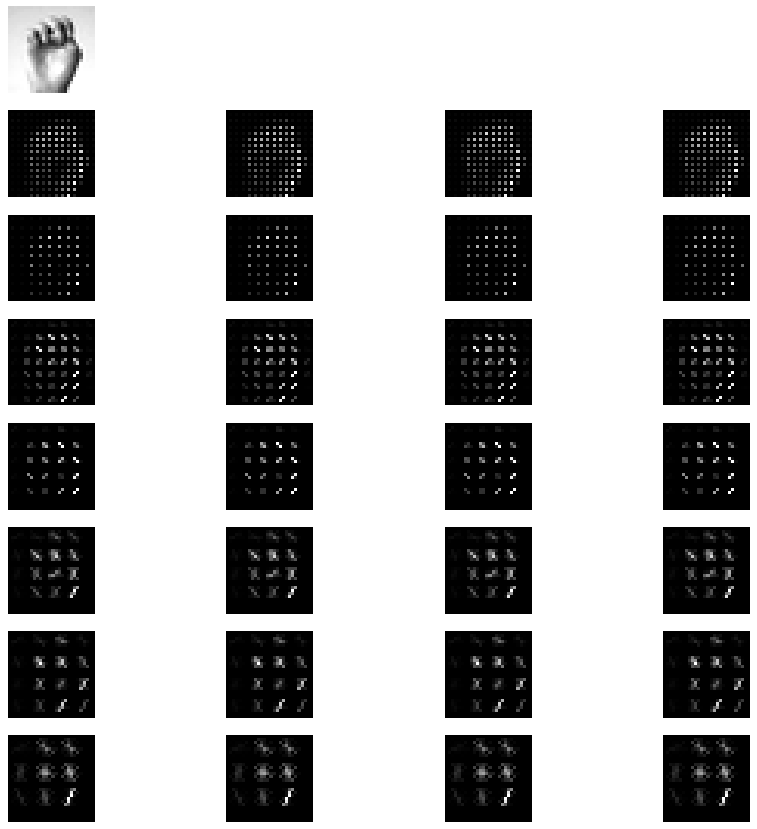

In [ ]:
# Show hog features
represent_index = 3
plt.figure(figsize=(15, 15))
plt.subplot(8, 4, 1)
plt.imshow(X_train[represent_index].reshape(28, 28), cmap='gray')
plt.axis('off')
cnt = 2
for n_pixel in range(2, 9):
  for n_cell in range(1, 5):
    _, represent_hog = hog(X_train[represent_index: 4].reshape((28, 28)), orientations=9, pixels_per_cell=(n_pixel, n_pixel), cells_per_block=(n_cell, n_cell), visualize=True)
    plt.subplot(8, 4, cnt + 3)
    cnt += 1
    plt.title('pixel=' + str(n_pixel) + ',cell=' + str(n_cell), color='w')
    plt.imshow(represent_hog, cmap='gray')
    plt.axis('off')
plt.show()

Dựa vào những hình ảnh đặc trưng cường độ HOG phía trên, dẽ dàng thấy các ảnh với kích thước cell là 2x2 thể hiện được hình dáng rõ ràng nhất, vậy nên đối với dữ liệu hiện tại, kích thước của cell sẽ là 2x2 và kích thước block là 1x1

In [ ]:
def save_pickle(data, filename):
  '''
    Write data to pickle file
  '''
  pickle.dump(data, open(filename, 'wb'))

def load_pickle(filename):
  """
    Load data from pickle file
  """
  return pickle.load(open(filename, 'rb'))

In [ ]:
# Features extraction using HOG
X_train_hog = call_parallel_extraction(X_train)
X_val_hog = call_parallel_extraction(X_val)

# Save HOG features to pickle file
save_pickle((X_train_hog, y_train), 'train_data.pkl')
save_pickle((X_val_hog, y_val), 'val_data.pkl')

100%|██████████| 27000/27000 [27:43<00:00, 16.23it/s]


In [ ]:
# Load saved features from pickle files
X_train_hog, y_train = load_pickle('train_data.pkl')
X_val_hog, y_val = load_pickle('val_data.pkl')

In [ ]:
X_val_hog.shape

(10800, 1764)

In [ ]:
# Train model again
start = timeit.default_timer()
model = LogisticRegression(max_iter=10000, penalty='l1', solver='saga')
model.fit(X_train_hog, y_train)
end = timeit.default_timer()
print("Time:", end-start)
print("Accuracy: %.2f" % (model.score(X_val_hog, y_val) * 100))

Sau khi thực hiện đánh giá lại mô hình với rút trích đặc trưng bằng HOG, kết quả độ chính xác tăng rất nhiều so với baseline.

Trực quan số lượng nhãn đúng và sai theo từng nhãn bằng Heatmap và Ma trận bối rối.

Text(0.5, 145.31999999999996, 'Predicted label')

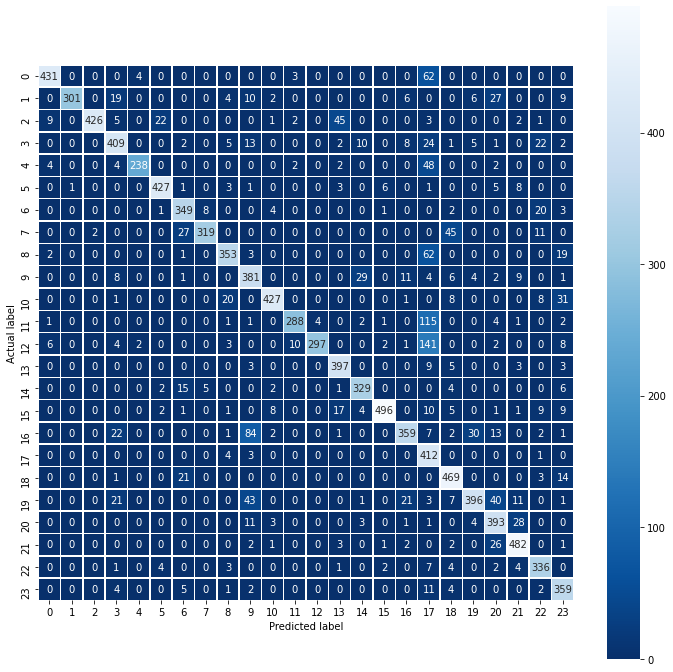

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true=y_val, y_pred = y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, 
            linewidths=.5, square = True, cmap = 'Blues_r', fmt='0.4g');

plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Dựa vào Ma trận bối rối ở trên, hiển thị các nhãn có nhiều lỗi sai để tìm ra nguyên nhân và đưa ra hướng giải quyết.

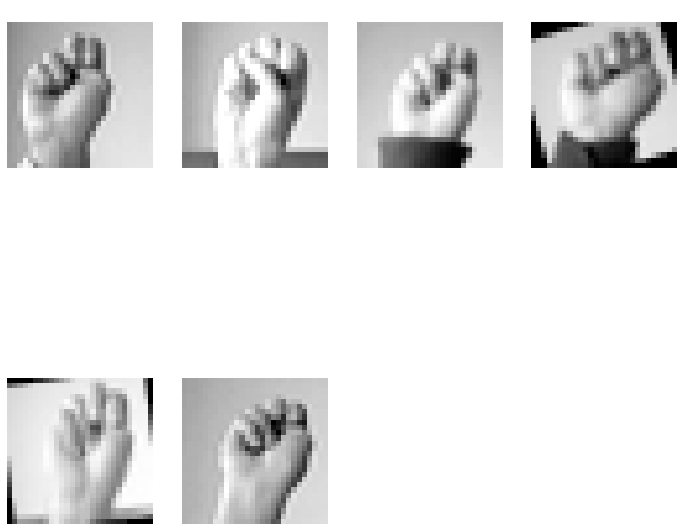

In [ ]:
show_image_by_condition(X_val, y_val, label_condition=[13, 18], numbers=6)

Nhận thấy, các trường hợp dễ bị phân loại sai có đặc trưng khá giống nhau. Nên để phân biệt giữa các loại này, ta sẽ sử dụng chiến lược One-versus-One, chiến lược này sẽ tạo ra $\frac{N * (N - 1)}{2}$ bộ phân loại nhị phân (Binary Classifier) để phân loại giữa các lớp, kết quả được tính bằng việc bầu chọn (vote) cho nhãn vượt trội nhất.

## Dimentionality Reduction: Principal Component Analysis

Sử dụng Phân tích thành phần chính để làm giảm số lượng đặc trưng ảnh nhằm tăng tốc độ huấn luyện dữ liệu.

Siêu tham số $C=\frac{1}{\lambda}$ theo tính chất sẽ làm mô hình phức tạp hơn, dễ bị overfitting hơn khi C lớn; ngược lại, C càng nhỏ thì mô hình càng đơn giản, và dễ bị underfitting hơn.

Thực hiện duyệt qua các khả năng và thử nghiệm siêu tham số hiệu quả nhất.

In [ ]:
# Set up hyperparameters
params = []
for n_component in np.arange(300, 1000, 50):
    for C_value in np.logspace(-3, 3, 7):
        params.append({
        "pca__n_components" : n_component,
        "clf__estimator__C" : C_value 
        })

best_score = 0
best_param = None

# Loop through hyperparameters and choose the best fit
for param in params:
    pipeline = Pipeline([
                      ('pca', PCA()),
                      ('clf', OneVsOneClassifier(
                          LogisticRegression(max_iter=10000, solver='lbfgs', multi_class='auto'))
                      )
    ])

    pipeline.set_params(**param)
    start = timeit.default_timer()
    pipeline.fit(X_train_hog, y_train)
    stop = timeit.default_timer()
    print("=============")
    print("Param", param)
    print("Training time: %.2f" % (stop - start))
    curr_score = pipeline.score(X_val_hog, y_val)
    print("Accuracy: %.2f" % (curr_score * 100))
    if curr_score > best_score:
        best_param = param
        best_score = curr_score

print("Best param:", best_param)

Param {'pca__n_components': 300, 'clf__C': 0.001}
Training time: 14.72
Accuracy: 78.30
Param {'pca__n_components': 300, 'clf__C': 0.01}
Training time: 17.00
Accuracy: 81.95
Param {'pca__n_components': 300, 'clf__C': 0.1}
Training time: 21.11
Accuracy: 81.28
Param {'pca__n_components': 300, 'clf__C': 1.0}
Training time: 23.63
Accuracy: 81.18
Param {'pca__n_components': 300, 'clf__C': 10.0}
Training time: 27.47
Accuracy: 81.41
Param {'pca__n_components': 300, 'clf__C': 100.0}
Training time: 29.24
Accuracy: 80.74
Param {'pca__n_components': 300, 'clf__C': 1000.0}
Training time: 27.99
Accuracy: 80.61
Param {'pca__n_components': 350, 'clf__C': 0.001}
Training time: 16.72
Accuracy: 79.03
Param {'pca__n_components': 350, 'clf__C': 0.01}
Training time: 19.19
Accuracy: 81.57
Param {'pca__n_components': 350, 'clf__C': 0.1}
Training time: 22.62
Accuracy: 81.67
Param {'pca__n_components': 350, 'clf__C': 1.0}
Training time: 26.03
Accuracy: 81.01
Param {'pca__n_components': 350, 'clf__C': 10.0}
Trai

Dựa vào quá trình thử nghiệm các siêu tham số phía trên, với số lượng đặc trưng sau khi rút trích đặc trưng n_components=950 và C=1000 trong One-versus-one Logistic Regression đem lại độ chính xác cao và thời gian tốt hơn.

In [ ]:
# Finally, choose the best number of components
pca = PCA(n_components=best_param['pca__n_components'])
X_train_pca = pca.fit_transform(X_train_hog)
X_val_pca = pca.transform(X_val_hog)

In [ ]:
# Train one-versus-one model
start = timeit.default_timer()

model = OneVsOneClassifier(LogisticRegression(C=best_param['clf__estimator__C'],
                                              max_iter=10000, 
                                              solver='lbfgs',
                                              multi_class='auto'))
model.fit(X_train_pca, y_train)

end = timeit.default_timer()
print("Fit time:", end - start)

y_pred = model.predict(X_val_pca)
missed_labels = np.sum(y_pred != y_val)
print("Accuracy: %.2f" % (accuracy_score(y_val, y_pred) * 100))
print("Missed Label: ", missed_labels)

Accuracy: 84.02


## Tổng kết

In [ ]:
 CONFIGS = {
    'C' : 1000,
    'MAX_ITER' : 10000,
    'N_COMPONENTS' : 950,
    'MODEL_PATH' : 'best_image_classifier.pkl',
}

def train(X_train, y_train, model=None):
    """
        Hàm huấn luyện mô hình phân loại.
        
        Parameters
        ----------
        X_train : ndarray
                Danh sách véc-tơ ảnh đầu vào.
        y_train : ndarray
                Danh sách nhãn của ảnh đầu vào.
        model : object (default:None)
                Mô hình phân lớp khởi tạo.
        
        Returns
        -------
        model : object
                Mô hình phân lớp sau khi đã được huấn luyện trên tập dữ liệu đầu vào.
    """

    X_train = call_parallel_extraction(X_train)

    print("=====TRAINING=====")
    if model is None:
        print("Step 0: Initializing model...")
        model = Pipeline([
                            ('pca', PCA(n_components=CONFIGS['N_COMPONENTS'])),
                            ('clf', OneVsOneClassifier(
                                LogisticRegression(C=CONFIGS['C'], 
                                                   max_iter=CONFIGS['MAX_ITER'], 
                                                   solver='lbfgs', multi_class='auto')))
        ])

    print("Step 1: Start training model...")
    model.fit(X_train, y_train)

    print("Step 2: Saving model...")
    save_pickle(model, CONFIGS['MODEL_PATH'])
    print("Finished training model!")
    return model

def predict(X_test, y_test, model=None):
    """
        Hàm dự đoán kết quả.
        
        Parameters
        ----------
        X_test : ndarray
                Danh sách véc-tơ ảnh đầu vào.
        y_test : ndarray
                Danh sách nhãn của ảnh đầu vào.
        model : object (default:None)
                Mô hình phân lớp.
        
        Returns
        -------
        accuracy : float
                Độ chính xác của tập dữ liệu.
        missed_labels : int
                Số lượng mẫu dự đoán sai.
    """

    X_test = call_parallel_extraction(X_test)

    print("=====PREDICTION=====")
    if model is None: 
        print("Step 0: Start loading model...")
        model = load_pickle(CONFIGS['MODEL_PATH'])

    print("Step 1: Predicting...")
    y_pred = model.predict(X_test)

    print("Step 2: Scoring model...")
    missed_labels = np.sum(y_pred != y_test)
    accuracy = accuracy_score(y_test, y_pred)

    print("Accuracy: {:.5f}".format(accuracy))
    print("Missed Label: ", missed_labels)

    print("Finished predicting model!")
    return accuracy, missed_labels


### Training

In [ ]:
# read data from csv file
X_train, y_train = read_file('train.csv')

# normalize data from 0 to 1 range 
X_train /= 255

# train
train(X_train, y_train)

# get training score
_ = predict(X_train, y_train)

### Testing

In [ ]:
# read data from csv
X_test, y_test = read_file('test.csv')

# normalize data
X_test /= 255

# predict test dataset
_ = predict(X_test, y_test)